# This notebook

## LOOK INTO. 
- Using more or less data.
    - Adding categorical data, removing nan data
- K-fold validation.
- Different activation functions.
- Combine some data for better training:
    - longiture/lattitude combined to distance from centre?
    - Combine stories/floor for a "penthouse" trait.
- one hot encoding for categorical data.
- alternative for filling in nan: mean doesnt work if 90% is nan, and the rest is 1 (balcony)
    - One idea: use a model to predict the value based on other data!
    - Simple idea: drop the features with too much nan (>30%)
- Use different loss function than MSLE? Maybe try with mse.

# Import

In [1]:
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from scipy import stats
# Specific tf libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

# Helper functions

In [126]:
%run utils.py
fractionOfData = 1

# Load data

## Metadata

In [3]:
metaData_apartment = pd.read_json('../data/apartments_meta.json')
metaData_building = pd.read_json('../data/buildings_meta.json')

In [4]:
metaData_apartment.at[0, 'name'] = 'apartment_id'
metaData_building.at[0, 'name'] = 'building_id'

In [5]:
metaData = pd.concat([metaData_apartment, metaData_building])

## Train data

In [6]:
train_apartment = pd.read_csv('../data/apartments_train.csv')

In [7]:
train_building = pd.read_csv('../data/buildings_train.csv')

In [8]:
train = pd.merge(train_apartment, train_building, left_on='building_id', right_on='id')
#train.rename(columns={'id_x' : 'apartment_id', 'id_y' : 'building_id'}, inplace=True)
train.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
train.drop('id_y', axis=1, inplace=True)
# Remove duplicate column after merge.

In [9]:
# Reduce amount of data for performance reasons during implementation.
train = train.head(int(train.shape[0] * fractionOfData))
train.head()

,apartment_id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,12,3.0,4045140.0,19.8,5.2,9.6,17.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
2,55,3.0,9500240.0,79.7,17.0,41.5,9.0,3.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,104,3.0,4326660.0,23.4,6.1,11.3,9.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
4,106,3.0,4333980.0,23.8,6.1,11.3,9.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN


## Test data

In [10]:
test_apartment = pd.read_csv('../data/apartments_test.csv')

In [11]:
test_building = pd.read_csv('../data/buildings_test.csv')

In [12]:
test = pd.merge(test_apartment, test_building, left_on='building_id', right_on='id')
test.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
test.drop('id_y', axis=1, inplace=True)
test.tail()

,apartment_id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
9932,33150,NaN,29.0,NaN,NaN,5.0,1.0,NaN,2.64,0.0,...,6,2014.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
9933,33153,NaN,87.0,12.0,NaN,6.0,3.0,NaN,2.50,0.0,...,105к2,NaN,NaN,17.0,0.0,1.0,1.0,NaN,NaN,NaN
9934,33163,NaN,58.1,12.0,30.0,14.0,2.0,1.0,2.70,0.0,...,12,2016.0,NaN,17.0,0.0,1.0,1.0,NaN,NaN,NaN
9935,33208,1.0,54.7,5.5,36.9,2.0,3.0,NaN,2.64,1.0,...,10К2,1963.0,4.0,5.0,1.0,0.0,0.0,NaN,NaN,0.0
9936,33221,1.0,71.5,7.0,49.0,2.0,3.0,NaN,NaN,NaN,...,2,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN


### The nan problem. Some of the data is too shallow for deep learning.

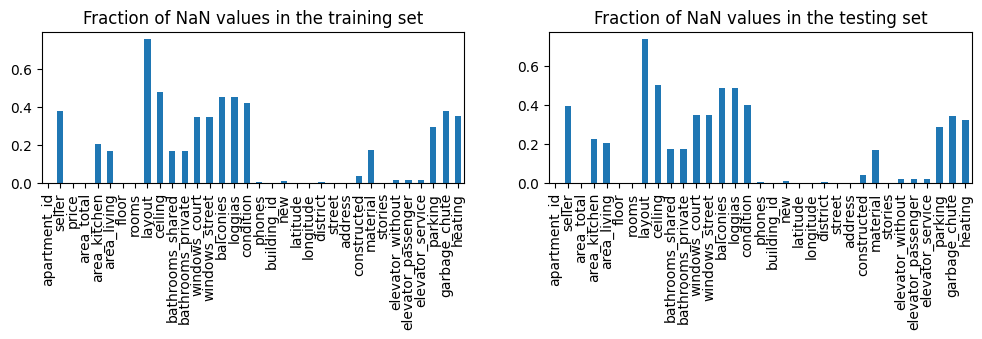

In [14]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 2), ncols=2, dpi=100)
train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set');

In [15]:
train.dtypes

apartment_id            int64
seller                float64
price                 float64
area_total            float64
area_kitchen          float64
area_living           float64
floor                 float64
rooms                 float64
layout                float64
ceiling               float64
bathrooms_shared      float64
bathrooms_private     float64
windows_court         float64
windows_street        float64
balconies             float64
loggias               float64
condition             float64
phones                float64
building_id             int64
new                   float64
latitude              float64
longitude             float64
district              float64
street                 object
address                object
constructed           float64
material              float64
stories               float64
elevator_without      float64
elevator_passenger    float64
elevator_service      float64
parking               float64
garbage_chute         float64
heating   

23197
23285


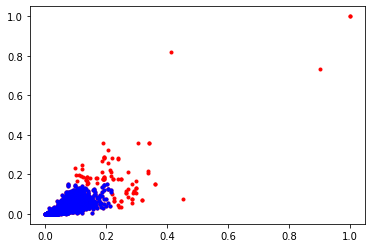

In [141]:
# Remove outlayers
outliers_value = 7
some_features = ["area_total", "area_kitchen", "area_living", "floor", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed", "price"]

normalized_train = train[some_features]
normalized_train = (normalized_train-normalized_train.min())/(normalized_train.max()-normalized_train.min())

no_outlayers = normalized_train[(np.abs(stats.zscore(normalized_train[["area_total", "price"]])) < outliers_value).all(axis=1)]
print(len(no_outlayers))
print(len(normalized_train))

plt.plot(normalized_train['area_total'], normalized_train['price'], 'r.')
plt.plot(no_outlayers['area_total'], no_outlayers['price'], 'b.')
#plt.xscale("log")
#plt.yscale("log")
plt.show()


## 1 - Expanding on the numerical data
Using longitude and lattitude better.

In [103]:
# "All" numerical features
numerical_features = ["area_total", "area_kitchen", "area_living", "floor", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed"]
outliers_value = 7

# Outlayer removal
no_outlayers = train[(np.abs(stats.zscore(train[["area_total", "price"]])) < outliers_value).all(axis=1)] 

# Labels and targets
labels1 = no_outlayers[numerical_features]
labels1 = labels1.fillna(labels1.mean())
targets1= no_outlayers['price'] # Non nan values here.

# Test
test1 = test[numerical_features]
test1 = test1.fillna(test1.mean())

# Normalize
normalized_labels1 = (labels1-labels1.min())/(labels1.max()-labels1.min())
normalized_test1 = (test1-test1.min())/(test1.max()-test1.min())

In [104]:
# Make a copy
labels1_normed_r = normalized_labels1.copy()
test1_normed_r = normalized_test1.copy()

# Move origo to centre
labels1_normed_r['latitude'] = labels1_normed_r['latitude'] -  labels1_normed_r['latitude'].mean()
labels1_normed_r['longitude'] = labels1_normed_r['longitude'] -  labels1_normed_r['longitude'].mean()
test1_normed_r['latitude'] = test1_normed_r['latitude'] -  test1_normed_r['latitude'].mean()
test1_normed_r['longitude'] = test1_normed_r['longitude'] -  test1_normed_r['longitude'].mean()

# Convert to polar coordinates
labels1_normed_r['r'] =  np.sqrt(labels1_normed_r['latitude']**2 + labels1_normed_r['longitude']**2)
labels1_normed_r['theta'] = np.arctan(labels1_normed_r['longitude']/labels1_normed_r['latitude'])
test1_normed_r['r'] =  np.sqrt(test1_normed_r['latitude']**2 + test1_normed_r['longitude']**2)
test1_normed_r['theta'] = np.arctan(test1_normed_r['longitude']/test1_normed_r['latitude'])

<AxesSubplot:xlabel='r', ylabel='theta'>

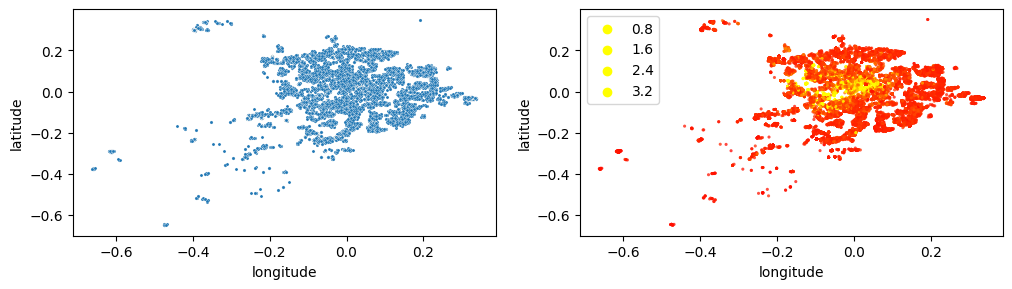

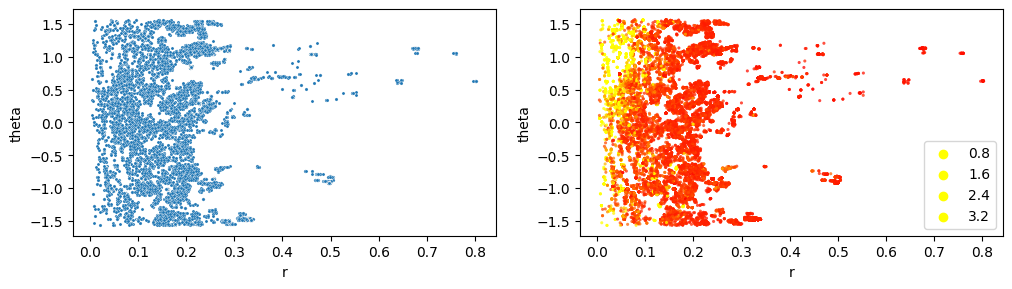

In [105]:
# Cartesian plot
fig, (ax1, ax2) = plt.subplots(figsize=(12, 3), ncols=2, dpi=100)
lo, hi = targets1.quantile([0.0, 0.9])
hue_norm = plt.Normalize(lo, hi)
hue = targets1.tolist()

sns.scatterplot(x='longitude', y='latitude', ax=ax1, alpha=1, s=5, data=labels1_normed_r[['latitude', 'longitude']])
sns.scatterplot(x='longitude', y='latitude', ax=ax2, hue=hue, alpha=0.75, s=5, palette="autumn", linewidth=0, hue_norm=hue_norm, data=labels1_normed_r[['latitude', 'longitude']])

# Polar plot
fig, (ax3, ax4) = plt.subplots(figsize=(12, 3), ncols=2, dpi=100)

sns.scatterplot(x='r', y='theta', ax=ax3, alpha=1, s=5, data=labels1_normed_r[['r', 'theta']])
sns.scatterplot(x='r', y='theta', ax=ax4, hue=hue, alpha=0.75, s=5, palette="autumn", linewidth=0, hue_norm=hue_norm, data=labels1_normed_r[['r', 'theta']])

In [106]:
labels1_normed_r.drop('latitude', inplace=True, axis=1)
labels1_normed_r.drop('longitude', inplace=True, axis=1)
test1_normed_r.drop('latitude', inplace=True, axis=1)
test1_normed_r.drop('longitude', inplace=True, axis=1)
labels1_normed_r.tail()

,area_total,area_kitchen,area_living,floor,rooms,ceiling,bathrooms_shared,bathrooms_private,balconies,constructed,r,theta
23280,0.135330,0.136364,0.066374,0.011111,0.2,0.008529,0.000000,0.250000,0.00000,0.958333,0.424582,0.691360
23281,0.056087,0.080808,0.073352,0.077778,0.0,0.009609,0.250000,0.000000,0.00000,0.809524,0.413492,0.696721
23282,0.103675,0.174747,0.084341,0.177778,0.2,0.008088,0.000000,0.250000,0.00000,0.928571,0.145669,-1.469908
23283,0.226684,0.117172,0.104636,0.011111,0.4,0.009609,0.183001,0.164888,0.13842,0.869048,0.248945,0.213095
23284,0.077332,0.109091,0.059890,0.088889,0.0,0.007941,0.250000,0.000000,0.25000,0.892857,0.144974,0.823417


### Train model on new data
Using same model and technique as used in initial test 5

In [107]:
# Model 1
model1 = tf.keras.Sequential()
model1.add(Dense(10, activation=tf.nn.relu)) #tf.keras.activations.sigmoid
model1.add(Dropout(0.2))
model1.add(Dense(10, activation=tf.nn.relu))
model1.add(Dropout(0.2))
model1.add(Dense(5, activation=tf.nn.relu))
model1.add(Dense(1)) #Output

# Optimized for reducing msle loss.
model1.compile(optimizer='adam', 
              loss='msle', #'msle'
              metrics=['msle']) #-msle

In [108]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=25) # 50
 
history1 = model1.fit(x=labels1_normed_r, y=targets1,
                    epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................Epoch 00432: early stopping


In [109]:
# Results
hist1 = pd.DataFrame(history1.history)
hist1['epoch'] = history1.epoch
hist1.tail(1)

,loss,msle,val_loss,val_msle,epoch
431,0.127813,0.127813,0.058022,0.058022,431


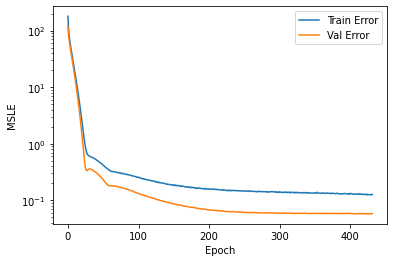

In [121]:
plot_history(hist1)

### Predict and submit

In [111]:
result1 = model1.predict(test1_normed_r)

In [112]:
submission_1 = pd.DataFrame()
submission_1['id'] = test['apartment_id']      
submission_1['price_prediction'] = result1
print("No. predictions:", len(submission_1['id']))

No. predictions: 9937


In [113]:
submission_1.to_csv('advanced_tests/advanced_test_1_1', index=False)

## 2 - Adding categorical data
First, we see that most categorical data is numerical. Easy solution: treat them like numerical data

In [127]:
# Extract, normalize, remove outliers
features = ["area_total", "area_kitchen", "area_living", "floor", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed", # Numerical
           "condition", "district", "material", "heating", "parking", "building_id"] #Categorical and more
labels2_n, test2_n, targets2 = preProcess_numericalData(features, train, test, outliers_value=7)

In [128]:
# Polar coordinates
labels2_n_r, test2_n_r = polar_coordinates(labels2_n, test2_n)

### Training

In [133]:
# Model 2
model2 = tf.keras.Sequential()
model2.add(Dense(10, activation=tf.nn.relu)) #tf.keras.activations.sigmoid
model2.add(Dropout(0.2))
model2.add(Dense(10, activation=tf.nn.relu))
model2.add(Dropout(0.2))
model2.add(Dense(5, activation=tf.nn.relu))
model2.add(Dense(1)) #Output

# Optimized for reducing msle loss.
model2.compile(optimizer='adam', 
              loss='msle', #'msle'
              metrics=['msle']) #-msle

In [134]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=25) # 50
history2 = model2.fit(x=labels2_n_r, y=targets2,
                    epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [135]:
# Results
hist2 = pd.DataFrame(history2.history)
hist2['epoch'] = history2.epoch
hist2.tail(1)

,loss,msle,val_loss,val_msle,epoch
999,0.105503,0.105503,0.054221,0.054221,999


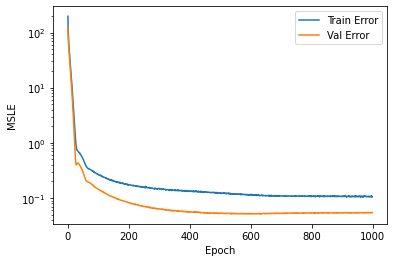

In [136]:
plot_history(hist2)

In [138]:
result = model2.predict(test2_n_r)
submission = pd.DataFrame()
submission['id'] = test['apartment_id']      
submission['price_prediction'] = result
print("No. predictions:", len(submission['id']))
submission.to_csv('advanced_tests/advanced_test_2', index=False)

No. predictions: 9937


## 3 - Special round


In [194]:
# Extract, normalize, remove outliers
features = ["area_total", "area_kitchen", "area_living", "floor", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed"]

# Extract labels, targets and preprocess
labels3_n, test3_n, targets3 = preProcess_numericalData(features, train, test, outliers_value=100)
labels3_n_r, test3_n_r = polar_coordinates(labels3_n, test3_n)

# Extract validation data
msk = np.random.rand(len(labels3_n_r)) < 0.9

train_labels = labels3_n_r[msk]
val_labels = labels3_n_r[~msk]

train_targets = targets3[msk]
val_targets = targets3[~msk]


In [196]:
# Model 3
model3 = tf.keras.Sequential()
model3.add(Dense(10, activation=tf.nn.relu)) #tf.keras.activations.sigmoid
model3.add(Dropout(0.2))
model3.add(Dense(10, activation=tf.nn.relu))
model3.add(Dropout(0.2))
model3.add(Dense(5, activation=tf.nn.relu))
model3.add(Dense(1)) #Output

# Optimized for reducing msle loss.
model3.compile(optimizer='adam', 
              loss='msle', #'msle'
              metrics=['msle']) #-msle

In [197]:
history3 = model3.fit(x=train_labels, y=train_targets,
                    epochs=1000, verbose=0, validation_data=(val_labels, val_targets),
                     callbacks=[early_stop, PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................Epoch 00759: early stopping


In [198]:
# Results
hist3 = pd.DataFrame(history3.history)
hist3['epoch'] = history3.epoch
hist3.tail(1)

,loss,msle,val_loss,val_msle,epoch
758,0.10949,0.10949,0.070124,0.070124,758


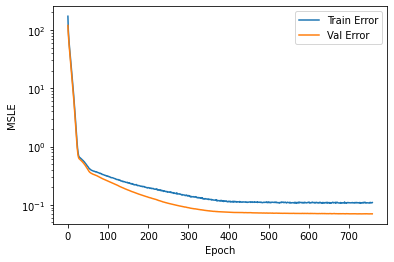

In [199]:
plot_history(hist3)

### Predict and save

In [201]:
result = model3.predict(test3_n_r)
submission = pd.DataFrame()
submission['id'] = test['apartment_id']      
submission['price_prediction'] = result
print("No. predictions:", len(submission['id']))
submission.to_csv('advanced_tests/advanced_test_3_2', index=False)

No. predictions: 9937


## 4 - K-fold validation
#### Sources
- https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/
- https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538